In [1]:
model_name = 'lightgbm'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.005
n_trials_tpe = 10
plot_param_importances = False
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
# Parameters
model_name = "xgboost"
device = "cpu"
min_samples_per_class = 5
n_classes = 8
n_frac = 0.1
n_trials_tpe = 1000
plot_param_importances = False
timeout_tpe = 3600
random_state = 42
n_jobs = -1


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [4]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [5]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [6]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [7]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [9]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [10]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{   'Benign': 3,
    'BruteForce': 7,
    'DDoS': 0,
    'DoS': 1,
    'Mirai': 2,
    'Recon': 5,
    'Spoofing': 4,
    'WebBased': 6}


In [11]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
0    3397209
1     809281
2     264004
3     109844
4      48837
5      35677
6       2539
7       1267
Name: count, dtype: int64

In [12]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

/tmp/ipykernel_2609680/2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [13]:
df_sample['label'].value_counts()

label
0    3398456
1     809073
2     263412
3     109819
4      48650
5      35456
6       2482
7       1306
Name: count, dtype: int64

In [14]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(4668654, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Max

In [15]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(4668654,)
int64
[0 1 2 3 4 5 6 7]
8


label
0    3398456
1     809073
2     263412
3     109819
4      48650
5      35456
6       2482
7       1306
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 2801192	(60.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Validation : 933731	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Test       : 933731	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]


In [17]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [19]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [20]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):868647

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-15 03:28:50,842] A new study created in memory with name: no-name-3ebdce61-be85-4dca-b157-d5e79aa52026


[I 2024-07-15 03:32:53,952] Trial 0 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-15 03:52:09,100] Trial 1 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-15 04:18:02,529] Trial 2 finished with value: 0.7766374917594722 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 2 with value: 0.7766374917594722.


[I 2024-07-15 04:43:54,051] Trial 3 finished with value: 0.7750185033940697 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 2 with value: 0.7766374917594722.


[I 2024-07-15 04:47:57,269] Trial 4 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-15 05:07:17,511] Trial 5 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-15 05:22:05,625] Trial 6 finished with value: 0.7809741784509764 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 6 with value: 0.7809741784509764.


[I 2024-07-15 05:42:48,794] Trial 7 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-15 06:03:02,568] Trial 8 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-15 06:23:50,688] Trial 9 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-15 06:44:32,517] Trial 10 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-15 06:48:39,350] Trial 11 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-15 07:02:26,888] Trial 12 finished with value: 0.7772488576032321 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 6 with value: 0.7809741784509764.


[I 2024-07-15 07:06:46,546] Trial 13 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-15 07:10:52,001] Trial 14 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-15 07:28:08,561] Trial 15 finished with value: 0.7767147272800046 and parameters: {'pp_method': 'standard', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 6 with value: 0.7809741784509764.


[I 2024-07-15 07:44:13,897] Trial 16 finished with value: 0.7778262784805324 and parameters: {'pp_method': 'minmax', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 6 with value: 0.7809741784509764.


[I 2024-07-15 08:10:10,223] Trial 17 finished with value: 0.7768107393463826 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 6 with value: 0.7809741784509764.


[I 2024-07-15 08:32:00,390] Trial 18 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-15 08:53:03,620] Trial 19 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-15 09:12:25,864] Trial 20 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-15 09:28:37,044] Trial 21 finished with value: 0.7778262784805324 and parameters: {'pp_method': 'none', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 6 with value: 0.7809741784509764.


[I 2024-07-15 09:42:20,474] Trial 22 finished with value: 0.7812157670970994 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 22 with value: 0.7812157670970994.


[I 2024-07-15 10:01:25,633] Trial 23 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-15 10:22:12,249] Trial 24 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-15 10:41:30,333] Trial 25 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-15 11:07:36,968] Trial 26 finished with value: 0.7750185033940697 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 22 with value: 0.7812157670970994.


[I 2024-07-15 11:21:30,941] Trial 27 finished with value: 0.7772488576032321 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 22 with value: 0.7812157670970994.


[I 2024-07-15 11:25:34,469] Trial 28 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-15 11:39:28,976] Trial 29 finished with value: 0.8334616299491451 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 29 with value: 0.8334616299491451.


[I 2024-07-15 11:53:16,669] Trial 30 finished with value: 0.7784367070557766 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 29 with value: 0.8334616299491451.


[I 2024-07-15 12:13:07,771] Trial 31 finished with value: 0.7772488576032321 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 29 with value: 0.8334616299491451.


[I 2024-07-15 12:39:55,528] Trial 32 finished with value: 0.8384676561665364 and parameters: {'pp_method': 'norm', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 32 with value: 0.8384676561665364.


[I 2024-07-15 12:56:02,124] Trial 33 finished with value: 0.7778262784805324 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 32 with value: 0.8384676561665364.


[I 2024-07-15 13:11:52,965] Trial 34 finished with value: 0.8352762139450699 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 32 with value: 0.8384676561665364.


[I 2024-07-15 13:37:59,507] Trial 35 finished with value: 0.7750185033940697 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 32 with value: 0.8384676561665364.


CPU times: user 25d 5h 21min 18s, sys: 18min 36s, total: 25d 5h 39min 54s
Wall time: 10h 9min 8s


In [21]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0       NaN 2024-07-15 03:28:50.842932 2024-07-15 03:32:53.952173   
1        1       NaN 2024-07-15 03:32:53.953191 2024-07-15 03:52:09.100167   
2        2  0.776637 2024-07-15 03:52:09.101080 2024-07-15 04:18:02.529144   
3        3  0.775019 2024-07-15 04:18:02.530208 2024-07-15 04:43:54.050976   
4        4       NaN 2024-07-15 04:43:54.051771 2024-07-15 04:47:57.269748   
5        5       NaN 2024-07-15 04:47:57.270509 2024-07-15 05:07:17.511592   
6        6  0.780974 2024-07-15 05:07:17.512308 2024-07-15 05:22:05.625656   
7        7       NaN 2024-07-15 05:22:05.626528 2024-07-15 05:42:48.794789   
8        8       NaN 2024-07-15 05:42:48.795496 2024-07-15 06:03:02.567977   
9        9       NaN 2024-07-15 06:03:02.568880 2024-07-15 06:23:50.688379   
10      10       NaN 2024-07-15 06:23:50.689153 2024-07-15 06:44:32.517787   
11      11       NaN 2024-07-15 06:44:32.518690 2024-07-15 06:48:39.349918   
12      12  0.777249 2024-07-15 06:48:39.350641 2024-07-15 07:02:26.887919   
13      13       NaN 2024-07-15 07:02:26.888966 2024-07-15 07:06:46.546614   
14      14       NaN 2024-07-15 07:06:46.547262 2024-07-15 07:10:52.000979   
15      15  0.776715 2024-07-15 07:10:52.001884 2024-07-15 07:28:08.561154   
16      16  0.777826 2024-07-15 07:28:08.562030 2024-07-15 07:44:13.897000   
17      17  0.776811 2024-07-15 07:44:13.898058 2024-07-15 08:10:10.223248   
18      18       NaN 2024-07-15 08:10:10.224302 2024-07-15 08:32:00.390636   
19      19       NaN 2024-07-15 08:32:00.391339 2024-07-15 08:53:03.620154   
20      20       NaN 2024-07-15 08:53:03.620972 2024-07-15 09:12:25.864377   
21      21  0.777826 2024-07-15 09:12:25.865261 2024-07-15 09:28:37.044231   
22      22  0.781216 2024-07-15 09:28:37.045302 2024-07-15 09:42:20.474408   
23      23       NaN 2024-07-15 09:42:20.475344 2024-07-15 10:01:25.633792   
24      24       NaN 2024-07-15 10:01:25.634573 2024-07-15 10:22:12.249307   
25      25       NaN 2024-07-15 10:22:12.250095 2024-07-15 10:41:30.333425   
26      26  0.775019 2024-07-15 10:41:30.334247 2024-07-15 11:07:36.968082   
27      27  0.777249 2024-07-15 11:07:36.969165 2024-07-15 11:21:30.941234   
28      28       NaN 2024-07-15 11:21:30.942314 2024-07-15 11:25:34.469546   
29      29  0.833462 2024-07-15 11:25:34.470457 2024-07-15 11:39:28.976601   
30      30  0.778437 2024-07-15 11:39:28.977459 2024-07-15 11:53:16.669803   
31      31  0.777249 2024-07-15 11:53:16.670867 2024-07-15 12:13:07.771747   
32      32  0.838468 2024-07-15 12:13:07.772622 2024-07-15 12:39:55.527893   
33      33  0.777826 2024-07-15 12:39:55.528969 2024-07-15 12:56:02.124759   
34      34  0.835276 2024-07-15 12:56:02.125651 2024-07-15 13:11:52.965685   
35      35  0.775019 2024-07-15 13:11:52.966761 2024-07-15 13:37:59.507797   

                 duration params_fs_method     params_fs_metric  \
0  0 days 00:04:03.109241           boruta     shap_importances   
1  0 days 00:19:15.146976              rfe     shap_importances   
2  0 days 00:25:53.428064              rfa  feature_importances   
3  0 days 00:25:51.520768              rfa  feature_importances   
4  0 days 00:04:03.217977           boruta     shap_importances   
5  0 days 00:19:20.241083              rfe     shap_importances   
6  0 days 00:14:48.113348           boruta  feature_importances   
7  0 days 00:20:43.168261              rfa     shap_importances   
8  0 days 00:20:13.772481              rfe     shap_importances   
9  0 days 00:20:48.119499              rfa     shap_importances   
10 0 days 00:20:41.828634              rfa     shap_importances   
11 0 days 00:04:06.831228           boruta     shap_importances   
12 0 days 00:13:47.537278              rfe  feature_importances   
13 0 days 00:04:19.657648           boruta     shap_importances   
14 0 days 00:04:05.453717           boruta     shap_importances   
15 0 days 00:17:16.559270           boruta  f

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [24]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

[W 2024-07-15 13:38:00,559] Param fs_metric unique value length is less than 2.


[W 2024-07-15 13:38:00,559] Param fs_metric unique value length is less than 2.


[W 2024-07-15 13:38:00,560] Param fs_metric unique value length is less than 2.


[W 2024-07-15 13:38:00,560] Param fs_metric unique value length is less than 2.


In [26]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [28]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [29]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [30]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [31]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-15 13:38:02,124] A new study created in memory with name: no-name-4fa66961-17fa-4c20-81ce-b5bcdbaa89a7


[I 2024-07-15 13:38:17,655] Trial 0 finished with value: 0.873689223817995 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.6}. Best is trial 0 with value: 0.873689223817995.


[I 2024-07-15 13:38:38,345] Trial 1 finished with value: 0.862764113436757 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.0}. Best is trial 0 with value: 0.873689223817995.


[I 2024-07-15 13:38:56,578] Trial 2 finished with value: 0.876854980365935 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.35}. Best is trial 2 with value: 0.876854980365935.


[I 2024-07-15 13:39:13,698] Trial 3 finished with value: 0.8732329044388367 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.7}. Best is trial 2 with value: 0.876854980365935.


[I 2024-07-15 13:39:29,026] Trial 4 finished with value: 0.8802480030876774 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.95}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:39:55,811] Trial 5 finished with value: 0.8233434547202687 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.4}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:40:13,172] Trial 6 finished with value: 0.8661485436872107 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.7}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:40:24,542] Trial 7 finished with value: 0.8681516329463879 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.9}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:40:45,150] Trial 8 finished with value: 0.8623648219798683 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.1}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:41:04,418] Trial 9 finished with value: 0.8653200787803286 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.35}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:41:22,309] Trial 10 finished with value: 0.8634704338184662 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.35}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:41:37,278] Trial 11 finished with value: 0.8633599842326043 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.75}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:41:54,348] Trial 12 finished with value: 0.8508487758407215 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.3}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:42:22,278] Trial 13 finished with value: 0.8243422254048047 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.1}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:42:43,052] Trial 14 finished with value: 0.8769489070405834 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.35}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:42:58,458] Trial 15 finished with value: 0.8671553889264514 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.85}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:43:14,717] Trial 16 finished with value: 0.8770956922261011 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.4}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:43:32,591] Trial 17 finished with value: 0.8706781948367631 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.95}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:43:47,657] Trial 18 finished with value: 0.8802480030876774 and parameters: {'over_threshold': 3.0, 'under_threshold': 'auto'}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:44:06,361] Trial 19 finished with value: 0.8746306617585761 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.65}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:44:20,942] Trial 20 finished with value: 0.8749474595136078 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.9}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:44:45,507] Trial 21 finished with value: 0.8225043716494179 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.95}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:45:03,437] Trial 22 finished with value: 0.85514221654414 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.05}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:45:15,359] Trial 23 finished with value: 0.8668114413053615 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.95}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:45:43,262] Trial 24 finished with value: 0.8206548048875656 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.15}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:45:59,537] Trial 25 finished with value: 0.8635465889658873 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.65}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:46:22,202] Trial 26 finished with value: 0.8753325186692159 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.05}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:46:34,874] Trial 27 finished with value: 0.866743130940038 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.95}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:46:50,593] Trial 28 finished with value: 0.8721853753282904 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.5}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:47:07,968] Trial 29 finished with value: 0.8719349922483683 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.9}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:47:24,802] Trial 30 finished with value: 0.862086141429637 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.55}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:47:42,712] Trial 31 finished with value: 0.8623350930817438 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.6}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:48:02,798] Trial 32 finished with value: 0.8588473569464653 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.25}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:48:17,295] Trial 33 finished with value: 0.8484247238207182 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.4}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:48:27,726] Trial 34 finished with value: 0.8606933920930033 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.75}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:48:48,878] Trial 35 finished with value: 0.862084959346586 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.15}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:49:07,280] Trial 36 finished with value: 0.8736108943266314 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.7}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:49:25,311] Trial 37 finished with value: 0.8574717477894525 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.25}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:49:42,920] Trial 38 finished with value: 0.8660561467066064 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.4}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:49:57,317] Trial 39 finished with value: 0.8650953076323834 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.85}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:50:17,607] Trial 40 finished with value: 0.8624528509768669 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.2}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:50:35,110] Trial 41 finished with value: 0.8672947770736628 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.3}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:50:55,492] Trial 42 finished with value: 0.8722900250736246 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.5}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:51:08,701] Trial 43 finished with value: 0.8747691845808286 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.9}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:51:18,384] Trial 44 finished with value: 0.8591444276665907 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.85}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:51:39,017] Trial 45 finished with value: 0.8732180727365405 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.25}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:51:51,147] Trial 46 finished with value: 0.8668114413053615 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.85}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:52:15,865] Trial 47 finished with value: 0.8225043716494179 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.9}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:52:29,467] Trial 48 finished with value: 0.8708899494833358 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.8}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:52:55,802] Trial 49 finished with value: 0.820538616172849 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.5}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:53:13,797] Trial 50 finished with value: 0.8642337460126255 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.65}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:53:32,429] Trial 51 finished with value: 0.8673653737081966 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.15}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:53:50,001] Trial 52 finished with value: 0.8725766136257669 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.65}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:54:02,419] Trial 53 finished with value: 0.866743130940038 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.9}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:54:21,016] Trial 54 finished with value: 0.8694312617312699 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.25}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:54:37,488] Trial 55 finished with value: 0.860659868935638 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.65}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:54:54,114] Trial 56 finished with value: 0.8704416515142936 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.6}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:55:09,592] Trial 57 finished with value: 0.8671553889264514 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.8}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:55:27,486] Trial 58 finished with value: 0.8384676561665364 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.0}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:55:44,025] Trial 59 finished with value: 0.8767921938074841 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.75}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:56:05,249] Trial 60 finished with value: 0.8656879734234104 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.25}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:56:25,923] Trial 61 finished with value: 0.8751181506643912 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.0}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:56:44,664] Trial 62 finished with value: 0.857936056367832 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.4}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:57:03,658] Trial 63 finished with value: 0.862823797421338 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.3}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:57:25,931] Trial 64 finished with value: 0.860914426324914 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.0}. Best is trial 4 with value: 0.8802480030876774.


[I 2024-07-15 13:57:40,397] Trial 65 finished with value: 0.8856662574073277 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 13:57:56,891] Trial 66 finished with value: 0.8665693072932703 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 13:58:14,782] Trial 67 finished with value: 0.8752075935496827 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 13:58:31,778] Trial 68 finished with value: 0.8688251887426692 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 13:58:47,782] Trial 69 finished with value: 0.8665693072932703 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 13:59:03,637] Trial 70 finished with value: 0.8620218984272394 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 13:59:28,453] Trial 71 finished with value: 0.8259882779612869 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 13:59:45,936] Trial 72 finished with value: 0.8752075935496827 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:00:07,564] Trial 73 finished with value: 0.8740097613004407 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:00:20,724] Trial 74 finished with value: 0.8680312872645327 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:00:39,233] Trial 75 finished with value: 0.8717011678552853 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:00:54,218] Trial 76 finished with value: 0.8802480030876774 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:01:13,213] Trial 77 finished with value: 0.8605720303458644 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:01:33,323] Trial 78 finished with value: 0.8612400275385389 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:01:45,866] Trial 79 finished with value: 0.8761980467396173 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:02:02,976] Trial 80 finished with value: 0.8747108599096682 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:02:20,644] Trial 81 finished with value: 0.8616093374397855 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:02:37,290] Trial 82 finished with value: 0.8695810792746314 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:02:56,322] Trial 83 finished with value: 0.8771157136086289 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:03:13,840] Trial 84 finished with value: 0.8622342583333164 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:03:33,036] Trial 85 finished with value: 0.8681419206669705 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:03:50,037] Trial 86 finished with value: 0.8672368714863026 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:04:03,754] Trial 87 finished with value: 0.8543084172678082 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:04:17,671] Trial 88 finished with value: 0.862655512865973 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:04:29,216] Trial 89 finished with value: 0.8721995730308272 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:04:47,051] Trial 90 finished with value: 0.8611311707851456 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:05:09,414] Trial 91 finished with value: 0.8704596788912722 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:05:27,488] Trial 92 finished with value: 0.8706781948367631 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:05:48,095] Trial 93 finished with value: 0.8582612722491245 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:06:04,789] Trial 94 finished with value: 0.8694018712447193 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:06:24,033] Trial 95 finished with value: 0.8677394757265819 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:06:41,606] Trial 96 finished with value: 0.8659301936969281 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:07:00,533] Trial 97 finished with value: 0.8740587522514193 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:07:21,026] Trial 98 finished with value: 0.8534028487749588 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:07:33,673] Trial 99 finished with value: 0.866743130940038 and parameters: {'over_threshold': 0.75, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:07:50,238] Trial 100 finished with value: 0.8713000653391179 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:08:05,614] Trial 101 finished with value: 0.8802480030876774 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:08:26,237] Trial 102 finished with value: 0.8722346845459223 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:08:45,954] Trial 103 finished with value: 0.8664474282880181 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:09:07,874] Trial 104 finished with value: 0.8717337874893155 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:09:26,140] Trial 105 finished with value: 0.8736013272086112 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:09:38,804] Trial 106 finished with value: 0.873482372931033 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:09:58,273] Trial 107 finished with value: 0.872378396410445 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:10:13,984] Trial 108 finished with value: 0.8632117818170386 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:10:38,333] Trial 109 finished with value: 0.8709376548118566 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:11:18,948] Trial 110 finished with value: 0.8216328385294571 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:11:36,407] Trial 111 finished with value: 0.8723273190736833 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:11:55,793] Trial 112 finished with value: 0.8743920105799989 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:12:10,880] Trial 113 finished with value: 0.876926118816455 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:12:26,788] Trial 114 finished with value: 0.8635277713846923 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:12:49,500] Trial 115 finished with value: 0.8640907682947754 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:13:06,046] Trial 116 finished with value: 0.8630386095510176 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:13:23,848] Trial 117 finished with value: 0.8719349922483683 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:13:41,383] Trial 118 finished with value: 0.8680348108610745 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:14:00,706] Trial 119 finished with value: 0.8735804948291357 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:14:21,044] Trial 120 finished with value: 0.8655183562785227 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:14:40,499] Trial 121 finished with value: 0.8647099497556058 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:14:54,833] Trial 122 finished with value: 0.862655512865973 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:15:11,777] Trial 123 finished with value: 0.8816687515033236 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:15:26,331] Trial 124 finished with value: 0.8650953076323834 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:15:45,093] Trial 125 finished with value: 0.8762809249449605 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:16:06,809] Trial 126 finished with value: 0.8733963487264547 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:16:22,716] Trial 127 finished with value: 0.8606884939772188 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:16:50,767] Trial 128 finished with value: 0.8201341398233699 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:17:07,481] Trial 129 finished with value: 0.8767081920413984 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:17:33,588] Trial 130 finished with value: 0.8493484093012401 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:17:50,600] Trial 131 finished with value: 0.8688448120983762 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:18:10,953] Trial 132 finished with value: 0.8681658585211955 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:18:32,734] Trial 133 finished with value: 0.8739508546709003 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:18:49,062] Trial 134 finished with value: 0.8546180281072782 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:19:10,070] Trial 135 finished with value: 0.8739569668068787 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:19:24,979] Trial 136 finished with value: 0.8802480030876774 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:19:44,421] Trial 137 finished with value: 0.8621373223771592 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:20:05,878] Trial 138 finished with value: 0.8595922068437121 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:20:30,908] Trial 139 finished with value: 0.8225043716494179 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:20:48,659] Trial 140 finished with value: 0.8771504086822572 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:21:02,251] Trial 141 finished with value: 0.862655512865973 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:21:22,114] Trial 142 finished with value: 0.8720921010867569 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:21:37,568] Trial 143 finished with value: 0.8660716342100132 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:21:55,214] Trial 144 finished with value: 0.8738504814554493 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:22:12,810] Trial 145 finished with value: 0.8549907455701156 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:22:29,840] Trial 146 finished with value: 0.8701290240375363 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:22:46,844] Trial 147 finished with value: 0.8736957282643478 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:23:00,297] Trial 148 finished with value: 0.8747691845808286 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:23:18,695] Trial 149 finished with value: 0.8635398364151764 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:23:36,539] Trial 150 finished with value: 0.8799551847287576 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:23:56,933] Trial 151 finished with value: 0.8660038616963207 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:24:09,118] Trial 152 finished with value: 0.8668114413053615 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:24:31,541] Trial 153 finished with value: 0.8714145318368456 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:24:45,843] Trial 154 finished with value: 0.8749474595136078 and parameters: {'over_threshold': 1.0, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:25:06,684] Trial 155 finished with value: 0.8657662643338788 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:25:24,168] Trial 156 finished with value: 0.8719349922483683 and parameters: {'over_threshold': 3.75, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:25:39,853] Trial 157 finished with value: 0.8671553889264514 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:26:02,036] Trial 158 finished with value: 0.8709781368747236 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:26:19,536] Trial 159 finished with value: 0.8641399885049859 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:26:37,216] Trial 160 finished with value: 0.8752075935496827 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:26:49,152] Trial 161 finished with value: 0.8611215549027847 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:27:10,995] Trial 162 finished with value: 0.8744335353366393 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:27:31,819] Trial 163 finished with value: 0.8669465722810706 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:27:51,531] Trial 164 finished with value: 0.8735781431160412 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:28:11,202] Trial 165 finished with value: 0.8583062210212421 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:28:33,141] Trial 166 finished with value: 0.872208677841654 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:28:49,190] Trial 167 finished with value: 0.8665693072932703 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:29:12,021] Trial 168 finished with value: 0.8538248180659117 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:29:29,142] Trial 169 finished with value: 0.8759712038191865 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:29:51,813] Trial 170 finished with value: 0.8719884426879072 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:30:10,060] Trial 171 finished with value: 0.8583186107199873 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:30:25,726] Trial 172 finished with value: 0.8681048102484745 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:30:42,125] Trial 173 finished with value: 0.8800493472338289 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:30:56,825] Trial 174 finished with value: 0.8636826486035517 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:31:16,179] Trial 175 finished with value: 0.8838929147732122 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:31:33,495] Trial 176 finished with value: 0.8646388251427305 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:31:50,179] Trial 177 finished with value: 0.8564659264896313 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:32:10,904] Trial 178 finished with value: 0.8727517644749626 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:32:25,827] Trial 179 finished with value: 0.8764492917338214 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:32:35,908] Trial 180 finished with value: 0.8619415687024266 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:32:50,185] Trial 181 finished with value: 0.8650953076323834 and parameters: {'over_threshold': 2.0, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:33:06,637] Trial 182 finished with value: 0.8764624143746167 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:33:33,215] Trial 183 finished with value: 0.8236494655714239 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:33:49,336] Trial 184 finished with value: 0.8524905918670656 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:34:04,506] Trial 185 finished with value: 0.8449411710705856 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:34:18,397] Trial 186 finished with value: 0.8611569322593093 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:34:37,558] Trial 187 finished with value: 0.8801183846066803 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:34:57,887] Trial 188 finished with value: 0.8585492467557043 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:35:26,645] Trial 189 finished with value: 0.824562550427308 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:35:44,604] Trial 190 finished with value: 0.8752075935496827 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:36:12,961] Trial 191 finished with value: 0.8228634894118636 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:36:30,937] Trial 192 finished with value: 0.8512633731743283 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:36:46,229] Trial 193 finished with value: 0.8628090027297888 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:37:05,610] Trial 194 finished with value: 0.8761642740519192 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:37:20,430] Trial 195 finished with value: 0.8856662574073277 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:37:30,146] Trial 196 finished with value: 0.8591444276665907 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:37:49,370] Trial 197 finished with value: 0.8664150330461085 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:38:04,477] Trial 198 finished with value: 0.8615663493317256 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:38:25,708] Trial 199 finished with value: 0.8557568689247237 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:38:41,163] Trial 200 finished with value: 0.8689028227113431 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:38:57,455] Trial 201 finished with value: 0.870702874486273 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:39:15,037] Trial 202 finished with value: 0.8703846129503653 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:39:29,682] Trial 203 finished with value: 0.8766891229285434 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:39:45,074] Trial 204 finished with value: 0.8810290173825492 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:39:59,515] Trial 205 finished with value: 0.8595666259775532 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:40:20,725] Trial 206 finished with value: 0.8556047944294669 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:40:38,818] Trial 207 finished with value: 0.8706781948367631 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:40:59,102] Trial 208 finished with value: 0.8760431648365061 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:41:10,785] Trial 209 finished with value: 0.8685985896629345 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:41:25,153] Trial 210 finished with value: 0.8636676101137538 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:41:40,722] Trial 211 finished with value: 0.8722153477880812 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:41:56,672] Trial 212 finished with value: 0.8678620609396064 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:42:16,414] Trial 213 finished with value: 0.8590553577606449 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:42:38,811] Trial 214 finished with value: 0.8746275198184069 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:42:56,439] Trial 215 finished with value: 0.8719349922483683 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:43:12,080] Trial 216 finished with value: 0.8780053652241642 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:43:23,970] Trial 217 finished with value: 0.8668114413053615 and parameters: {'over_threshold': 0.5, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:43:40,025] Trial 218 finished with value: 0.875291291524187 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:43:56,889] Trial 219 finished with value: 0.8803920675295007 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:44:18,030] Trial 220 finished with value: 0.8738178321317707 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:44:42,752] Trial 221 finished with value: 0.8225043716494179 and parameters: {'over_threshold': 'auto', 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:45:02,734] Trial 222 finished with value: 0.8740833436120217 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:45:18,878] Trial 223 finished with value: 0.8536945484775749 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:45:34,035] Trial 224 finished with value: 0.8743860090525373 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:45:50,935] Trial 225 finished with value: 0.8706781948367631 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:46:06,967] Trial 226 finished with value: 0.8767081920413984 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:46:23,099] Trial 227 finished with value: 0.8479230912683924 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:46:37,908] Trial 228 finished with value: 0.8749474595136078 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:46:50,545] Trial 229 finished with value: 0.866743130940038 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:47:05,875] Trial 230 finished with value: 0.8749474595136078 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:47:18,693] Trial 231 finished with value: 0.8517314324667123 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:47:41,419] Trial 232 finished with value: 0.8641151305397192 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:48:02,729] Trial 233 finished with value: 0.8723758404545319 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:48:24,072] Trial 234 finished with value: 0.8621632728427093 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:48:44,154] Trial 235 finished with value: 0.8539900410337091 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:49:06,135] Trial 236 finished with value: 0.8626169822973094 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:49:22,351] Trial 237 finished with value: 0.8665693072932703 and parameters: {'over_threshold': 3.5, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:49:39,023] Trial 238 finished with value: 0.8555506833306991 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:49:52,197] Trial 239 finished with value: 0.8607555336541755 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:50:11,205] Trial 240 finished with value: 0.867049972809713 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:50:22,250] Trial 241 finished with value: 0.8735721854144978 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:50:40,010] Trial 242 finished with value: 0.8523468112016761 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:50:56,197] Trial 243 finished with value: 0.8767081920413984 and parameters: {'over_threshold': 4.0, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:51:13,246] Trial 244 finished with value: 0.8741632710378019 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:51:29,552] Trial 245 finished with value: 0.8590214434924568 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:51:47,636] Trial 246 finished with value: 0.8752075935496827 and parameters: {'over_threshold': 3.25, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:52:06,591] Trial 247 finished with value: 0.8573389469570083 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:52:25,726] Trial 248 finished with value: 0.8633293994918907 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:52:42,692] Trial 249 finished with value: 0.8798642712300436 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:52:53,707] Trial 250 finished with value: 0.8525088490550043 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:53:19,268] Trial 251 finished with value: 0.8220031260194085 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:53:47,109] Trial 252 finished with value: 0.8222925579132505 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:54:05,140] Trial 253 finished with value: 0.8706747136873332 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:54:19,226] Trial 254 finished with value: 0.8674535195447923 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:54:40,531] Trial 255 finished with value: 0.8656169136158907 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:55:01,427] Trial 256 finished with value: 0.8649760960697064 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:55:23,261] Trial 257 finished with value: 0.8753500776879597 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:55:35,676] Trial 258 finished with value: 0.8726223050233757 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:55:51,678] Trial 259 finished with value: 0.8796221659288472 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:56:10,567] Trial 260 finished with value: 0.8694808384721122 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:56:26,568] Trial 261 finished with value: 0.8665693072932703 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:56:44,482] Trial 262 finished with value: 0.8771881959830967 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:56:57,881] Trial 263 finished with value: 0.8747691845808286 and parameters: {'over_threshold': 1.25, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:57:11,502] Trial 264 finished with value: 0.8639034958346188 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:57:29,964] Trial 265 finished with value: 0.8735889897521267 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:57:47,578] Trial 266 finished with value: 0.8475541143280652 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:58:01,803] Trial 267 finished with value: 0.8716528124637559 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:58:24,310] Trial 268 finished with value: 0.8708829179922235 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:58:46,035] Trial 269 finished with value: 0.8669620025863121 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:59:06,364] Trial 270 finished with value: 0.8744041232138202 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:59:23,591] Trial 271 finished with value: 0.8737611454489627 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:59:44,288] Trial 272 finished with value: 0.8638937490194467 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 14:59:58,117] Trial 273 finished with value: 0.862655512865973 and parameters: {'over_threshold': 1.5, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:00:22,547] Trial 274 finished with value: 0.8225043716494179 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:00:38,095] Trial 275 finished with value: 0.8671553889264514 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:00:59,827] Trial 276 finished with value: 0.8695268769017737 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:01:21,923] Trial 277 finished with value: 0.8771670720915958 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:01:36,235] Trial 278 finished with value: 0.8763617987522194 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.6}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:01:52,129] Trial 279 finished with value: 0.8822934343598815 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:02:09,999] Trial 280 finished with value: 0.8622029664987172 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:02:29,380] Trial 281 finished with value: 0.8759728373217834 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:02:48,634] Trial 282 finished with value: 0.8742163426785958 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:03:11,316] Trial 283 finished with value: 0.8681877813431662 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:03:28,421] Trial 284 finished with value: 0.8708204616016739 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:03:44,636] Trial 285 finished with value: 0.8767081920413984 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:04:04,068] Trial 286 finished with value: 0.8630965349894597 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:04:25,597] Trial 287 finished with value: 0.8656543882026155 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:04:43,178] Trial 288 finished with value: 0.8719349922483683 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:05:07,072] Trial 289 finished with value: 0.8702749889857828 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:05:26,771] Trial 290 finished with value: 0.8779821822841236 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:05:48,363] Trial 291 finished with value: 0.8670878469830821 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:06:14,543] Trial 292 finished with value: 0.8223579671861885 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:06:29,568] Trial 293 finished with value: 0.8672806232349901 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:06:48,295] Trial 294 finished with value: 0.8713590534649389 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:07:03,827] Trial 295 finished with value: 0.8772975122879478 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:07:23,775] Trial 296 finished with value: 0.8541515031813728 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:07:40,316] Trial 297 finished with value: 0.8796221659288472 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:07:59,537] Trial 298 finished with value: 0.8622929264402083 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:08:15,703] Trial 299 finished with value: 0.859438554947104 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:08:35,976] Trial 300 finished with value: 0.8754807814433427 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:08:52,200] Trial 301 finished with value: 0.8641983141862861 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:09:03,306] Trial 302 finished with value: 0.8681516329463879 and parameters: {'over_threshold': 0.25, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:09:15,023] Trial 303 finished with value: 0.8591444276665907 and parameters: {'over_threshold': 0.0, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:09:38,702] Trial 304 finished with value: 0.868382834969174 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:09:57,532] Trial 305 finished with value: 0.8619459381736583 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:10:19,412] Trial 306 finished with value: 0.8512687237231942 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:10:32,543] Trial 307 finished with value: 0.8574856133176159 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:10:54,003] Trial 308 finished with value: 0.8735282533202748 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:11:09,967] Trial 309 finished with value: 0.8796221659288472 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.9}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:11:34,423] Trial 310 finished with value: 0.8225043716494179 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:11:53,452] Trial 311 finished with value: 0.869238989209153 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:12:12,302] Trial 312 finished with value: 0.8566722871498449 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:12:27,035] Trial 313 finished with value: 0.8668856142034922 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:12:40,434] Trial 314 finished with value: 0.8747691845808286 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:12:54,743] Trial 315 finished with value: 0.869642985685165 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:13:13,443] Trial 316 finished with value: 0.857954177209058 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:13:30,893] Trial 317 finished with value: 0.8751986253854138 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:13:45,788] Trial 318 finished with value: 0.8639555231700655 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:14:01,661] Trial 319 finished with value: 0.8796221659288472 and parameters: {'over_threshold': 1.75, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:14:20,202] Trial 320 finished with value: 0.8705882792067049 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:14:41,554] Trial 321 finished with value: 0.8713113283978788 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:14:56,256] Trial 322 finished with value: 0.8856662574073277 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:15:16,004] Trial 323 finished with value: 0.8782897965875371 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:15:35,521] Trial 324 finished with value: 0.8564800733151421 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:15:55,056] Trial 325 finished with value: 0.8555951220549736 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:16:11,833] Trial 326 finished with value: 0.8512808278114259 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:16:34,594] Trial 327 finished with value: 0.8775732842824374 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:16:54,651] Trial 328 finished with value: 0.8645709747207109 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:17:17,662] Trial 329 finished with value: 0.8656792664886083 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:17:32,834] Trial 330 finished with value: 0.8832469679357869 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.8}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:17:56,645] Trial 331 finished with value: 0.8641504696300513 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:18:15,362] Trial 332 finished with value: 0.8551101771665197 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.0}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:18:29,428] Trial 333 finished with value: 0.8650953076323834 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:18:45,744] Trial 334 finished with value: 0.8767081920413984 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:19:07,654] Trial 335 finished with value: 0.8606886857703802 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:19:28,280] Trial 336 finished with value: 0.8714938534459621 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:19:41,936] Trial 337 finished with value: 0.8656540416825399 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:20:03,202] Trial 338 finished with value: 0.8694594806473623 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:20:22,602] Trial 339 finished with value: 0.8554667053273857 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:20:36,632] Trial 340 finished with value: 0.8697403402982372 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:20:56,558] Trial 341 finished with value: 0.8681683826928539 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:21:16,393] Trial 342 finished with value: 0.8697750289366728 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:21:27,522] Trial 343 finished with value: 0.8681516329463879 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:21:50,279] Trial 344 finished with value: 0.8733426079409456 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:22:09,487] Trial 345 finished with value: 0.8670886140644797 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:22:28,535] Trial 346 finished with value: 0.8696147505648186 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:22:46,775] Trial 347 finished with value: 0.8611120925106309 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.1}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:23:06,808] Trial 348 finished with value: 0.8733037931785942 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:23:30,036] Trial 349 finished with value: 0.8714669591095814 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:23:39,628] Trial 350 finished with value: 0.8591444276665907 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.95}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:23:56,453] Trial 351 finished with value: 0.8684535323692227 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:24:18,676] Trial 352 finished with value: 0.8695402470262692 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:24:37,490] Trial 353 finished with value: 0.876674103239292 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.75}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:24:58,691] Trial 354 finished with value: 0.8734936328367983 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:25:18,139] Trial 355 finished with value: 0.8712055731051003 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:25:36,857] Trial 356 finished with value: 0.8540963439085636 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.3}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:26:01,771] Trial 357 finished with value: 0.8260027121488522 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.7}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:26:21,721] Trial 358 finished with value: 0.8767926634461224 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.4}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:26:32,913] Trial 359 finished with value: 0.8681516329463879 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.85}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:26:56,160] Trial 360 finished with value: 0.8728340705729295 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:27:17,096] Trial 361 finished with value: 0.8645944289476175 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:27:32,370] Trial 362 finished with value: 0.8856662574073277 and parameters: {'over_threshold': 2.25, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:28:01,133] Trial 363 finished with value: 0.8209005481527532 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:28:18,030] Trial 364 finished with value: 0.8706781948367631 and parameters: {'over_threshold': 2.5, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:28:33,440] Trial 365 finished with value: 0.8671553889264514 and parameters: {'over_threshold': 2.75, 'under_threshold': 'auto'}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:28:52,258] Trial 366 finished with value: 0.8767093540355817 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:29:10,895] Trial 367 finished with value: 0.859398190642331 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.05}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:29:28,670] Trial 368 finished with value: 0.8690482310175529 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:29:43,567] Trial 369 finished with value: 0.8620820074107337 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.55}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:30:01,217] Trial 370 finished with value: 0.8720265600208602 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:30:18,677] Trial 371 finished with value: 0.8791846636736895 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.45}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:30:36,810] Trial 372 finished with value: 0.8711166662203764 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.2}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:30:56,946] Trial 373 finished with value: 0.8663157251066764 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.15}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:31:19,335] Trial 374 finished with value: 0.8632315963364167 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.25}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:31:33,409] Trial 375 finished with value: 0.8697208432882282 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.65}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:31:48,159] Trial 376 finished with value: 0.8538167373082073 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.5}. Best is trial 65 with value: 0.8856662574073277.


[I 2024-07-15 15:32:05,781] Trial 377 finished with value: 0.8706994513406372 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.35}. Best is trial 65 with value: 0.8856662574073277.


CPU times: user 3d 22h 56min 31s, sys: 3min 9s, total: 3d 22h 59min 41s
Wall time: 1h 54min 3s


In [32]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.873689 2024-07-15 13:38:02.125389 2024-07-15 13:38:17.654949   
1         1  0.862764 2024-07-15 13:38:17.655968 2024-07-15 13:38:38.345141   
2         2  0.876855 2024-07-15 13:38:38.346215 2024-07-15 13:38:56.578645   
3         3  0.873233 2024-07-15 13:38:56.579726 2024-07-15 13:39:13.698274   
4         4  0.880248 2024-07-15 13:39:13.699213 2024-07-15 13:39:29.025996   
..      ...       ...                        ...                        ...   
373     373  0.866316 2024-07-15 15:30:36.811205 2024-07-15 15:30:56.945881   
374     374  0.863232 2024-07-15 15:30:56.946882 2024-07-15 15:31:19.335020   
375     375  0.869721 2024-07-15 15:31:19.335895 2024-07-15 15:31:33.409148   
376     376  0.853817 2024-07-15 15:31:33.409984 2024-07-15 15:31:48.159655   
377     377  0.870699 2024-07-15 15:31:48.160564 2024-07-15 15:32:05.781646   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:00:15.529560                  1.25                    0.6   
1   0 days 00:00:20.689173                   1.5                    0.0   
2   0 days 00:00:18.232430                   2.0                   0.35   
3   0 days 00:00:17.118548                  1.75                    0.7   
4   0 days 00:00:15.326783                   3.0                   0.95   
..                     ...                   ...                    ...   
373 0 days 00:00:20.134676                   3.0                   0.15   
374 0 days 00:00:22.388138                   2.5                   0.25   
375 0 days 00:00:14.073253                  0.75                   0.65   
376 0 days 00:00:14.749671                  0.25                    0.5   
377 0 days 00:00:17.621082                  2.25                   0.35   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [35]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [36]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [37]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [38]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2024-07-15 15:32:09,175] A new study created in memory with name: no-name-47a6706e-a123-4449-9977-45a022b4e653


[I 2024-07-15 15:32:24,867] Trial 0 finished with value: 0.8863823104284991 and parameters: {'n_estimators': 76, 'max_depth': 16, 'learning_rate': 0.15635132648457697, 'subsample': 0.5428498273806142, 'colsample_bytree': 0.832388135531515}. Best is trial 0 with value: 0.8863823104284991.


[I 2024-07-15 15:32:29,101] Trial 1 finished with value: 0.8095354748657198 and parameters: {'n_estimators': 45, 'max_depth': 2, 'learning_rate': 0.22414510404091065, 'subsample': 0.8409279329803734, 'colsample_bytree': 0.5828119982038846}. Best is trial 0 with value: 0.8863823104284991.


[I 2024-07-15 15:32:59,753] Trial 2 finished with value: 0.8855564752395697 and parameters: {'n_estimators': 141, 'max_depth': 20, 'learning_rate': 0.1819419349556656, 'subsample': 0.5878159670295819, 'colsample_bytree': 0.5380991318300224}. Best is trial 0 with value: 0.8863823104284991.


[I 2024-07-15 15:33:33,718] Trial 3 finished with value: 0.88874849708063 and parameters: {'n_estimators': 178, 'max_depth': 16, 'learning_rate': 0.06754702088572961, 'subsample': 0.9232587293784781, 'colsample_bytree': 0.8617909163566626}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:33:59,297] Trial 4 finished with value: 0.8863584799670483 and parameters: {'n_estimators': 151, 'max_depth': 12, 'learning_rate': 0.14839313366457263, 'subsample': 0.7086037842203585, 'colsample_bytree': 0.9834338602750592}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:34:31,757] Trial 5 finished with value: 0.8841474954064059 and parameters: {'n_estimators': 194, 'max_depth': 12, 'learning_rate': 0.1556651651112178, 'subsample': 0.8773346888393091, 'colsample_bytree': 0.5101505634888128}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:34:36,321] Trial 6 finished with value: 0.8808457975892414 and parameters: {'n_estimators': 14, 'max_depth': 18, 'learning_rate': 0.12214851264334574, 'subsample': 0.9214385966913076, 'colsample_bytree': 0.5976917722196049}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:35:08,913] Trial 7 finished with value: 0.8869791568393023 and parameters: {'n_estimators': 158, 'max_depth': 17, 'learning_rate': 0.11220661200089291, 'subsample': 0.6156538335794258, 'colsample_bytree': 0.7771752359975764}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:35:49,861] Trial 8 finished with value: 0.8859631003688476 and parameters: {'n_estimators': 199, 'max_depth': 19, 'learning_rate': 0.14491552677615133, 'subsample': 0.8288049017199113, 'colsample_bytree': 0.9665819612716966}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:35:56,457] Trial 9 finished with value: 0.880061214163036 and parameters: {'n_estimators': 39, 'max_depth': 11, 'learning_rate': 0.0976249818116267, 'subsample': 0.8427624400439659, 'colsample_bytree': 0.5408918262022269}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:36:08,291] Trial 10 finished with value: 0.8292946637761399 and parameters: {'n_estimators': 110, 'max_depth': 5, 'learning_rate': 0.017966145667725114, 'subsample': 0.9878833065140503, 'colsample_bytree': 0.8624305596140269}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:36:39,954] Trial 11 finished with value: 0.8854619096709135 and parameters: {'n_estimators': 163, 'max_depth': 16, 'learning_rate': 0.05538496478896648, 'subsample': 0.6702747859503168, 'colsample_bytree': 0.7213230611661128}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:37:03,253] Trial 12 finished with value: 0.8867160515885351 and parameters: {'n_estimators': 122, 'max_depth': 15, 'learning_rate': 0.2925155688449155, 'subsample': 0.6251013060057834, 'colsample_bytree': 0.7302760087766401}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:37:26,075] Trial 13 finished with value: 0.8860820579751734 and parameters: {'n_estimators': 173, 'max_depth': 8, 'learning_rate': 0.07631346853076552, 'subsample': 0.7609634859074835, 'colsample_bytree': 0.8217524790518471}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:37:50,484] Trial 14 finished with value: 0.8831628921591061 and parameters: {'n_estimators': 134, 'max_depth': 14, 'learning_rate': 0.025357836812203625, 'subsample': 0.5147828699803769, 'colsample_bytree': 0.8994293818877337}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:38:10,995] Trial 15 finished with value: 0.8848756829337392 and parameters: {'n_estimators': 90, 'max_depth': 18, 'learning_rate': 0.06234661307782867, 'subsample': 0.7546275518374936, 'colsample_bytree': 0.6707549875532937}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:38:35,971] Trial 16 finished with value: 0.8861618983991831 and parameters: {'n_estimators': 180, 'max_depth': 9, 'learning_rate': 0.10242235555941746, 'subsample': 0.9676853874287678, 'colsample_bytree': 0.7870326903196858}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:39:04,224] Trial 17 finished with value: 0.887201989783735 and parameters: {'n_estimators': 156, 'max_depth': 14, 'learning_rate': 0.24160913292026687, 'subsample': 0.6777782413875696, 'colsample_bytree': 0.9055831201825868}. Best is trial 3 with value: 0.88874849708063.


[I 2024-07-15 15:39:36,337] Trial 18 finished with value: 0.8889765421370719 and parameters: {'n_estimators': 180, 'max_depth': 14, 'learning_rate': 0.25682974267431796, 'subsample': 0.7897630246139459, 'colsample_bytree': 0.8823648099505998}. Best is trial 18 with value: 0.8889765421370719.


[I 2024-07-15 15:40:02,078] Trial 19 finished with value: 0.8852901092201395 and parameters: {'n_estimators': 182, 'max_depth': 9, 'learning_rate': 0.2697547084970705, 'subsample': 0.9134841333822326, 'colsample_bytree': 0.9322195198598849}. Best is trial 18 with value: 0.8889765421370719.


[I 2024-07-15 15:40:18,405] Trial 20 finished with value: 0.8866654300867978 and parameters: {'n_estimators': 90, 'max_depth': 13, 'learning_rate': 0.1920944796573809, 'subsample': 0.788726660615684, 'colsample_bytree': 0.8629723547465237}. Best is trial 18 with value: 0.8889765421370719.


[I 2024-07-15 15:40:49,901] Trial 21 finished with value: 0.8881874734099022 and parameters: {'n_estimators': 170, 'max_depth': 15, 'learning_rate': 0.2513188892946844, 'subsample': 0.69587133107933, 'colsample_bytree': 0.9250177713202871}. Best is trial 18 with value: 0.8889765421370719.


[I 2024-07-15 15:41:22,875] Trial 22 finished with value: 0.8865759409775882 and parameters: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.23423814675673257, 'subsample': 0.6952702502333669, 'colsample_bytree': 0.9386783345648384}. Best is trial 18 with value: 0.8889765421370719.


[I 2024-07-15 15:41:54,758] Trial 23 finished with value: 0.8875833802998128 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.26052271844236036, 'subsample': 0.7863805199747586, 'colsample_bytree': 0.995649504432627}. Best is trial 18 with value: 0.8889765421370719.


[I 2024-07-15 15:42:22,981] Trial 24 finished with value: 0.8875758338237633 and parameters: {'n_estimators': 135, 'max_depth': 17, 'learning_rate': 0.20745308336436344, 'subsample': 0.7279712436758493, 'colsample_bytree': 0.8848129145453553}. Best is trial 18 with value: 0.8889765421370719.


[I 2024-07-15 15:42:53,495] Trial 25 finished with value: 0.8890273826119361 and parameters: {'n_estimators': 169, 'max_depth': 14, 'learning_rate': 0.29908511378933766, 'subsample': 0.9427197477246447, 'colsample_bytree': 0.8299498152118693}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:43:25,095] Trial 26 finished with value: 0.8875689805135951 and parameters: {'n_estimators': 186, 'max_depth': 13, 'learning_rate': 0.28817441332480376, 'subsample': 0.9314332095875526, 'colsample_bytree': 0.8180595676689262}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:43:43,513] Trial 27 finished with value: 0.8854825474205985 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.27782498387999205, 'subsample': 0.8918444176202733, 'colsample_bytree': 0.6973303980520245}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:44:17,965] Trial 28 finished with value: 0.8849975512150683 and parameters: {'n_estimators': 166, 'max_depth': 20, 'learning_rate': 0.2974148141320596, 'subsample': 0.997033779388167, 'colsample_bytree': 0.770928286762905}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:44:42,731] Trial 29 finished with value: 0.8887028959725363 and parameters: {'n_estimators': 124, 'max_depth': 16, 'learning_rate': 0.17500006866587686, 'subsample': 0.9417082018575536, 'colsample_bytree': 0.8404371777479662}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:44:52,733] Trial 30 finished with value: 0.8847855038119796 and parameters: {'n_estimators': 66, 'max_depth': 10, 'learning_rate': 0.21438340618012267, 'subsample': 0.8745193649516367, 'colsample_bytree': 0.8088585570899651}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:45:16,946] Trial 31 finished with value: 0.8881900832234493 and parameters: {'n_estimators': 120, 'max_depth': 16, 'learning_rate': 0.17861542974301095, 'subsample': 0.9576500681001011, 'colsample_bytree': 0.8508126514248326}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:45:40,433] Trial 32 finished with value: 0.8862554036332548 and parameters: {'n_estimators': 128, 'max_depth': 14, 'learning_rate': 0.13141748457689087, 'subsample': 0.9517693697079599, 'colsample_bytree': 0.8450223203667249}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:46:02,401] Trial 33 finished with value: 0.8878275556227345 and parameters: {'n_estimators': 107, 'max_depth': 17, 'learning_rate': 0.17636233986735794, 'subsample': 0.8386790878137607, 'colsample_bytree': 0.8881471819237966}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:46:28,299] Trial 34 finished with value: 0.88708458081339 and parameters: {'n_estimators': 149, 'max_depth': 13, 'learning_rate': 0.227855706549771, 'subsample': 0.9018662811965006, 'colsample_bytree': 0.798179804862953}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:46:56,734] Trial 35 finished with value: 0.8885020891910158 and parameters: {'n_estimators': 143, 'max_depth': 16, 'learning_rate': 0.2022733372953554, 'subsample': 0.8693413233166926, 'colsample_bytree': 0.7588810497886603}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:47:32,947] Trial 36 finished with value: 0.8888699931454884 and parameters: {'n_estimators': 188, 'max_depth': 19, 'learning_rate': 0.2744036891100145, 'subsample': 0.9442818523016555, 'colsample_bytree': 0.9512926498042157}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:47:48,840] Trial 37 finished with value: 0.8605300663310236 and parameters: {'n_estimators': 190, 'max_depth': 2, 'learning_rate': 0.27146539283251137, 'subsample': 0.8105209095854873, 'colsample_bytree': 0.9561363604248903}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:48:25,944] Trial 38 finished with value: 0.8864688563556219 and parameters: {'n_estimators': 190, 'max_depth': 19, 'learning_rate': 0.24554795309407834, 'subsample': 0.9809502890004294, 'colsample_bytree': 0.9737974000929731}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:48:57,293] Trial 39 finished with value: 0.8873803591068055 and parameters: {'n_estimators': 162, 'max_depth': 18, 'learning_rate': 0.29951462456304473, 'subsample': 0.9243999198886107, 'colsample_bytree': 0.8769722644909345}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:49:31,440] Trial 40 finished with value: 0.8855444947431526 and parameters: {'n_estimators': 171, 'max_depth': 20, 'learning_rate': 0.25669994248955547, 'subsample': 0.85760925075861, 'colsample_bytree': 0.9192652689923586}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:50:02,848] Trial 41 finished with value: 0.8858635820325196 and parameters: {'n_estimators': 193, 'max_depth': 12, 'learning_rate': 0.28265206321085673, 'subsample': 0.938897916632122, 'colsample_bytree': 0.8350695685022397}. Best is trial 25 with value: 0.8890273826119361.


[I 2024-07-15 15:50:35,441] Trial 42 finished with value: 0.889499716374465 and parameters: {'n_estimators': 154, 'max_depth': 18, 'learning_rate': 0.1667860615819837, 'subsample': 0.894667336443211, 'colsample_bytree': 0.9460844473885738}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:51:07,743] Trial 43 finished with value: 0.8881185994847116 and parameters: {'n_estimators': 154, 'max_depth': 19, 'learning_rate': 0.162169071633052, 'subsample': 0.89355409226484, 'colsample_bytree': 0.9510045190209803}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:51:48,694] Trial 44 finished with value: 0.886826434448659 and parameters: {'n_estimators': 179, 'max_depth': 18, 'learning_rate': 0.033370300727150554, 'subsample': 0.9741357314118091, 'colsample_bytree': 0.9102528934257652}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:52:29,546] Trial 45 finished with value: 0.8880717847442563 and parameters: {'n_estimators': 199, 'max_depth': 17, 'learning_rate': 0.08466744307662136, 'subsample': 0.8140046345025053, 'colsample_bytree': 0.982706861141515}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:53:03,708] Trial 46 finished with value: 0.8879673123906521 and parameters: {'n_estimators': 161, 'max_depth': 19, 'learning_rate': 0.14139494985793286, 'subsample': 0.9101908265550627, 'colsample_bytree': 0.8671709143330183}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:53:37,169] Trial 47 finished with value: 0.8860529960388667 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.26346232865979646, 'subsample': 0.5718486843603126, 'colsample_bytree': 0.9555909489625847}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:54:17,003] Trial 48 finished with value: 0.8870460228999204 and parameters: {'n_estimators': 186, 'max_depth': 19, 'learning_rate': 0.11952024650005752, 'subsample': 0.8463284431351792, 'colsample_bytree': 0.6359252307600395}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:54:50,334] Trial 49 finished with value: 0.8867312867932429 and parameters: {'n_estimators': 168, 'max_depth': 16, 'learning_rate': 0.05361120378617361, 'subsample': 0.9994802888183382, 'colsample_bytree': 0.8988914154830988}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:54:58,882] Trial 50 finished with value: 0.8861469777288993 and parameters: {'n_estimators': 37, 'max_depth': 18, 'learning_rate': 0.2797052897587223, 'subsample': 0.8880668375891348, 'colsample_bytree': 0.9339766753173113}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:55:18,643] Trial 51 finished with value: 0.8882096484234774 and parameters: {'n_estimators': 97, 'max_depth': 16, 'learning_rate': 0.1531067574050629, 'subsample': 0.9548501930034696, 'colsample_bytree': 0.8326642005715224}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:55:43,956] Trial 52 finished with value: 0.8872505241990476 and parameters: {'n_estimators': 137, 'max_depth': 14, 'learning_rate': 0.1880481841325347, 'subsample': 0.935186333712408, 'colsample_bytree': 0.8599878934982635}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:56:08,144] Trial 53 finished with value: 0.8884397390998203 and parameters: {'n_estimators': 117, 'max_depth': 17, 'learning_rate': 0.1688400877740597, 'subsample': 0.9462478163969928, 'colsample_bytree': 0.8830808307619397}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:56:38,258] Trial 54 finished with value: 0.8878278230758236 and parameters: {'n_estimators': 160, 'max_depth': 15, 'learning_rate': 0.21741896301139357, 'subsample': 0.9163989259848382, 'colsample_bytree': 0.7903854617401795}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:57:04,172] Trial 55 finished with value: 0.8876051254254362 and parameters: {'n_estimators': 151, 'max_depth': 12, 'learning_rate': 0.13605139460281113, 'subsample': 0.6422543670506401, 'colsample_bytree': 0.9990377032360447}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:57:51,036] Trial 56 finished with value: 0.8837754079432831 and parameters: {'n_estimators': 175, 'max_depth': 20, 'learning_rate': 0.010188980282413086, 'subsample': 0.8645357937290762, 'colsample_bytree': 0.9089761294897489}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:58:23,154] Trial 57 finished with value: 0.889270679109337 and parameters: {'n_estimators': 182, 'max_depth': 13, 'learning_rate': 0.1072174811418189, 'subsample': 0.9686541504625282, 'colsample_bytree': 0.7305784606654333}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:58:51,508] Trial 58 finished with value: 0.8865511657135526 and parameters: {'n_estimators': 184, 'max_depth': 11, 'learning_rate': 0.0944772388405691, 'subsample': 0.9796847772230792, 'colsample_bytree': 0.6844892777160294}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:59:24,397] Trial 59 finished with value: 0.8872778468924087 and parameters: {'n_estimators': 194, 'max_depth': 13, 'learning_rate': 0.06830031203142714, 'subsample': 0.7370061733976023, 'colsample_bytree': 0.7344389128896252}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 15:59:51,212] Trial 60 finished with value: 0.8842804477809858 and parameters: {'n_estimators': 169, 'max_depth': 12, 'learning_rate': 0.042845555697431675, 'subsample': 0.9627011605786379, 'colsample_bytree': 0.6545562830632765}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:00:23,898] Trial 61 finished with value: 0.888369190687517 and parameters: {'n_estimators': 178, 'max_depth': 14, 'learning_rate': 0.11599455264664343, 'subsample': 0.928168891059012, 'colsample_bytree': 0.751884229677797}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:00:49,662] Trial 62 finished with value: 0.8875049683317049 and parameters: {'n_estimators': 129, 'max_depth': 16, 'learning_rate': 0.10312177876770869, 'subsample': 0.9678452826200158, 'colsample_bytree': 0.7196568574848352}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:01:25,029] Trial 63 finished with value: 0.8870587360424304 and parameters: {'n_estimators': 184, 'max_depth': 15, 'learning_rate': 0.12773888532963604, 'subsample': 0.7725565576765556, 'colsample_bytree': 0.8108165873587698}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:01:39,424] Trial 64 finished with value: 0.8865962550812634 and parameters: {'n_estimators': 74, 'max_depth': 14, 'learning_rate': 0.29147064098283754, 'subsample': 0.9069113385790898, 'colsample_bytree': 0.8447301628532613}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:02:09,560] Trial 65 finished with value: 0.8850622088369502 and parameters: {'n_estimators': 147, 'max_depth': 17, 'learning_rate': 0.08400388513398785, 'subsample': 0.8822813801110053, 'colsample_bytree': 0.5669531910889491}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:02:42,610] Trial 66 finished with value: 0.8885152379995392 and parameters: {'n_estimators': 191, 'max_depth': 13, 'learning_rate': 0.23748091687342002, 'subsample': 0.9484994808092319, 'colsample_bytree': 0.7700339378629156}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:03:12,906] Trial 67 finished with value: 0.8876826580813437 and parameters: {'n_estimators': 158, 'max_depth': 15, 'learning_rate': 0.19604781780841396, 'subsample': 0.9879120588022166, 'colsample_bytree': 0.9418685312243725}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:03:47,392] Trial 68 finished with value: 0.8878341022106475 and parameters: {'n_estimators': 167, 'max_depth': 18, 'learning_rate': 0.15000019788043123, 'subsample': 0.922170683076726, 'colsample_bytree': 0.8255376526434042}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:04:25,589] Trial 69 finished with value: 0.8852854432407071 and parameters: {'n_estimators': 199, 'max_depth': 18, 'learning_rate': 0.2727566568269285, 'subsample': 0.9005595311938269, 'colsample_bytree': 0.9726343046368685}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:04:28,634] Trial 70 finished with value: 0.8824526996070401 and parameters: {'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.28720079567752155, 'subsample': 0.9397033880326184, 'colsample_bytree': 0.8969666664548144}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:05:01,533] Trial 71 finished with value: 0.8879858383790353 and parameters: {'n_estimators': 192, 'max_depth': 13, 'learning_rate': 0.23845085422583068, 'subsample': 0.951356963188427, 'colsample_bytree': 0.7732573319992362}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:05:39,178] Trial 72 finished with value: 0.8864154335793193 and parameters: {'n_estimators': 187, 'max_depth': 14, 'learning_rate': 0.2508099508058744, 'subsample': 0.9669323986017049, 'colsample_bytree': 0.7103329708698592}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:06:10,271] Trial 73 finished with value: 0.8862353030454564 and parameters: {'n_estimators': 181, 'max_depth': 13, 'learning_rate': 0.23043001995635143, 'subsample': 0.9409027310392262, 'colsample_bytree': 0.7995669162030152}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:06:37,456] Trial 74 finished with value: 0.8870871960784578 and parameters: {'n_estimators': 174, 'max_depth': 11, 'learning_rate': 0.16800262983011754, 'subsample': 0.9913604976000201, 'colsample_bytree': 0.7797948289047498}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:07:06,624] Trial 75 finished with value: 0.8862558325262191 and parameters: {'n_estimators': 196, 'max_depth': 10, 'learning_rate': 0.2593747911848724, 'subsample': 0.9187529738597249, 'colsample_bytree': 0.7369527682666054}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:07:35,298] Trial 76 finished with value: 0.8860619505866534 and parameters: {'n_estimators': 173, 'max_depth': 12, 'learning_rate': 0.2692064931592462, 'subsample': 0.8194912185374583, 'colsample_bytree': 0.8701963574775238}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:08:07,624] Trial 77 finished with value: 0.8880884916389504 and parameters: {'n_estimators': 164, 'max_depth': 17, 'learning_rate': 0.21640132360577177, 'subsample': 0.9789401002192692, 'colsample_bytree': 0.852206213398343}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:08:28,753] Trial 78 finished with value: 0.888453967199678 and parameters: {'n_estimators': 114, 'max_depth': 14, 'learning_rate': 0.20413515310319322, 'subsample': 0.9455166404766961, 'colsample_bytree': 0.757931897523431}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:08:44,988] Trial 79 finished with value: 0.8809906279090899 and parameters: {'n_estimators': 155, 'max_depth': 4, 'learning_rate': 0.25065365450933497, 'subsample': 0.8832945710594511, 'colsample_bytree': 0.8386364945269454}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:09:19,522] Trial 80 finished with value: 0.8880880634885446 and parameters: {'n_estimators': 188, 'max_depth': 16, 'learning_rate': 0.29784579329521244, 'subsample': 0.7932834900741617, 'colsample_bytree': 0.8123211846878855}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:09:47,691] Trial 81 finished with value: 0.88727600925976 and parameters: {'n_estimators': 142, 'max_depth': 16, 'learning_rate': 0.19848832520130236, 'subsample': 0.8676514048693746, 'colsample_bytree': 0.7500688599485577}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:10:13,262] Trial 82 finished with value: 0.8890711937015814 and parameters: {'n_estimators': 128, 'max_depth': 16, 'learning_rate': 0.1891803187551115, 'subsample': 0.8553221612549162, 'colsample_bytree': 0.7673103245522935}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:10:35,723] Trial 83 finished with value: 0.8871405735732976 and parameters: {'n_estimators': 126, 'max_depth': 13, 'learning_rate': 0.1812850335237191, 'subsample': 0.9013949874030858, 'colsample_bytree': 0.921497333900059}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:11:01,910] Trial 84 finished with value: 0.886289350981781 and parameters: {'n_estimators': 137, 'max_depth': 15, 'learning_rate': 0.15990291920084593, 'subsample': 0.8411106506660013, 'colsample_bytree': 0.7934962986214691}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:11:37,339] Trial 85 finished with value: 0.8881002790296358 and parameters: {'n_estimators': 181, 'max_depth': 17, 'learning_rate': 0.18852895615027265, 'subsample': 0.9293288155525585, 'colsample_bytree': 0.8272615453857115}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:12:01,910] Trial 86 finished with value: 0.8864464692811511 and parameters: {'n_estimators': 111, 'max_depth': 19, 'learning_rate': 0.1693830302464109, 'subsample': 0.9606214824570429, 'colsample_bytree': 0.8874823336443288}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:12:34,122] Trial 87 finished with value: 0.8885266064254765 and parameters: {'n_estimators': 177, 'max_depth': 14, 'learning_rate': 0.1434727753194329, 'subsample': 0.8545769673940404, 'colsample_bytree': 0.7666882704336353}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:12:55,831] Trial 88 finished with value: 0.8866098369726085 and parameters: {'n_estimators': 105, 'max_depth': 17, 'learning_rate': 0.10628931157745104, 'subsample': 0.8562235471531242, 'colsample_bytree': 0.7009289009500167}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:13:17,690] Trial 89 finished with value: 0.8868726124786237 and parameters: {'n_estimators': 97, 'max_depth': 20, 'learning_rate': 0.17490613071772412, 'subsample': 0.8278325716258178, 'colsample_bytree': 0.8553127714161074}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:13:43,402] Trial 90 finished with value: 0.8873616358436465 and parameters: {'n_estimators': 131, 'max_depth': 16, 'learning_rate': 0.14552493665597388, 'subsample': 0.7946473110098307, 'colsample_bytree': 0.740666421147899}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:14:15,672] Trial 91 finished with value: 0.8863275871607583 and parameters: {'n_estimators': 175, 'max_depth': 14, 'learning_rate': 0.13695423641368218, 'subsample': 0.8514601789590159, 'colsample_bytree': 0.7618725311008184}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:14:35,656] Trial 92 finished with value: 0.8877306807258212 and parameters: {'n_estimators': 123, 'max_depth': 12, 'learning_rate': 0.12442151265193027, 'subsample': 0.8933362872915953, 'colsample_bytree': 0.72319895504827}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:15:06,537] Trial 93 finished with value: 0.8842518457809951 and parameters: {'n_estimators': 177, 'max_depth': 13, 'learning_rate': 0.2651006300978424, 'subsample': 0.5051435244025255, 'colsample_bytree': 0.7708321811290388}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:15:42,517] Trial 94 finished with value: 0.8884566060570294 and parameters: {'n_estimators': 190, 'max_depth': 15, 'learning_rate': 0.2224192093932074, 'subsample': 0.9128261287020366, 'colsample_bytree': 0.7817660828260008}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:16:10,833] Trial 95 finished with value: 0.8888748779999955 and parameters: {'n_estimators': 164, 'max_depth': 13, 'learning_rate': 0.28397357612267576, 'subsample': 0.8791305893203792, 'colsample_bytree': 0.9835571170505524}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:16:42,870] Trial 96 finished with value: 0.8864012970216288 and parameters: {'n_estimators': 163, 'max_depth': 18, 'learning_rate': 0.2822266658939054, 'subsample': 0.8766811957378842, 'colsample_bytree': 0.9576181269961562}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:17:13,981] Trial 97 finished with value: 0.8888366682956266 and parameters: {'n_estimators': 170, 'max_depth': 15, 'learning_rate': 0.276294171074346, 'subsample': 0.8337452493237794, 'colsample_bytree': 0.9756749844063886}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:17:46,374] Trial 98 finished with value: 0.8874121622572897 and parameters: {'n_estimators': 170, 'max_depth': 15, 'learning_rate': 0.27528105763740934, 'subsample': 0.8056865077876005, 'colsample_bytree': 0.9862672107153589}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:18:15,912] Trial 99 finished with value: 0.888084291224071 and parameters: {'n_estimators': 157, 'max_depth': 16, 'learning_rate': 0.28690187893237973, 'subsample': 0.8215396218001214, 'colsample_bytree': 0.9468242161592675}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:18:45,554] Trial 100 finished with value: 0.8863596525641697 and parameters: {'n_estimators': 151, 'max_depth': 19, 'learning_rate': 0.29383069675387385, 'subsample': 0.8345039257235486, 'colsample_bytree': 0.9688671176654975}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:19:20,959] Trial 101 finished with value: 0.8884362399724046 and parameters: {'n_estimators': 166, 'max_depth': 14, 'learning_rate': 0.1589247273725243, 'subsample': 0.7681937867927704, 'colsample_bytree': 0.9887448519866857}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:19:55,502] Trial 102 finished with value: 0.8879802748832866 and parameters: {'n_estimators': 183, 'max_depth': 15, 'learning_rate': 0.08997462705778765, 'subsample': 0.85981019631576, 'colsample_bytree': 0.93041391946869}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:20:29,003] Trial 103 finished with value: 0.8889912687855365 and parameters: {'n_estimators': 171, 'max_depth': 16, 'learning_rate': 0.074285006814619, 'subsample': 0.8755168437657092, 'colsample_bytree': 0.9601463411081412}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:21:03,721] Trial 104 finished with value: 0.887804305179211 and parameters: {'n_estimators': 171, 'max_depth': 17, 'learning_rate': 0.05580547056350199, 'subsample': 0.8741007693004631, 'colsample_bytree': 0.9786252842523775}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:21:31,276] Trial 105 finished with value: 0.8867144286397369 and parameters: {'n_estimators': 147, 'max_depth': 15, 'learning_rate': 0.04845288833882723, 'subsample': 0.8926636670828613, 'colsample_bytree': 0.9614773074347286}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:22:02,158] Trial 106 finished with value: 0.8877713768965769 and parameters: {'n_estimators': 160, 'max_depth': 16, 'learning_rate': 0.0607220535637879, 'subsample': 0.9327279418900971, 'colsample_bytree': 0.91812653199782}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:22:32,779] Trial 107 finished with value: 0.8871940201701829 and parameters: {'n_estimators': 153, 'max_depth': 17, 'learning_rate': 0.08156271756554323, 'subsample': 0.9046686879275005, 'colsample_bytree': 0.9937839855196215}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:23:07,182] Trial 108 finished with value: 0.8874938125517933 and parameters: {'n_estimators': 167, 'max_depth': 18, 'learning_rate': 0.06930855543389958, 'subsample': 0.8062433782692539, 'colsample_bytree': 0.9396165769392639}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:23:41,030] Trial 109 finished with value: 0.8873972464697611 and parameters: {'n_estimators': 184, 'max_depth': 16, 'learning_rate': 0.27893835274795836, 'subsample': 0.9214232858956211, 'colsample_bytree': 0.9665280439561713}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:24:16,680] Trial 110 finished with value: 0.8867697877505076 and parameters: {'n_estimators': 180, 'max_depth': 16, 'learning_rate': 0.034783020083656135, 'subsample': 0.7372174452734724, 'colsample_bytree': 0.9470865624177939}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:24:48,161] Trial 111 finished with value: 0.8877874737840921 and parameters: {'n_estimators': 177, 'max_depth': 14, 'learning_rate': 0.0766538512450472, 'subsample': 0.8461390963116946, 'colsample_bytree': 0.8712227984394842}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:25:19,459] Trial 112 finished with value: 0.8878378361673892 and parameters: {'n_estimators': 173, 'max_depth': 14, 'learning_rate': 0.26741983788804274, 'subsample': 0.8699666812132244, 'colsample_bytree': 0.9767928100888386}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:25:49,419] Trial 113 finished with value: 0.8864443504413106 and parameters: {'n_estimators': 170, 'max_depth': 14, 'learning_rate': 0.2915300064845883, 'subsample': 0.8860512531160022, 'colsample_bytree': 0.9072978843430645}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:26:19,156] Trial 114 finished with value: 0.8852160881672929 and parameters: {'n_estimators': 162, 'max_depth': 15, 'learning_rate': 0.2998139044141283, 'subsample': 0.7797197724060932, 'colsample_bytree': 0.8040246041151113}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:26:53,987] Trial 115 finished with value: 0.8871693780025274 and parameters: {'n_estimators': 195, 'max_depth': 13, 'learning_rate': 0.25496684094608235, 'subsample': 0.8318059429834421, 'colsample_bytree': 0.8972394595079063}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:27:17,553] Trial 116 finished with value: 0.88586439111015 and parameters: {'n_estimators': 139, 'max_depth': 12, 'learning_rate': 0.2835126909630319, 'subsample': 0.859294200902884, 'colsample_bytree': 0.9980698481371186}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:27:49,878] Trial 117 finished with value: 0.8873820390941309 and parameters: {'n_estimators': 178, 'max_depth': 13, 'learning_rate': 0.16521662606333506, 'subsample': 0.9745298740717251, 'colsample_bytree': 0.8190665094016925}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:28:23,746] Trial 118 finished with value: 0.8881334761702034 and parameters: {'n_estimators': 186, 'max_depth': 14, 'learning_rate': 0.11201005254206699, 'subsample': 0.9145450259644999, 'colsample_bytree': 0.9303467274947522}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:28:42,731] Trial 119 finished with value: 0.8893092125076447 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1516578017576297, 'subsample': 0.9527913950687146, 'colsample_bytree': 0.8804249890777569}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:28:58,090] Trial 120 finished with value: 0.885813357475397 and parameters: {'n_estimators': 76, 'max_depth': 15, 'learning_rate': 0.18789437041724422, 'subsample': 0.9657684697144395, 'colsample_bytree': 0.50091414467971}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:29:16,641] Trial 121 finished with value: 0.8875781034507415 and parameters: {'n_estimators': 96, 'max_depth': 15, 'learning_rate': 0.15361713697395488, 'subsample': 0.9552687446293677, 'colsample_bytree': 0.8569875504051386}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:29:46,770] Trial 122 finished with value: 0.8894671090925477 and parameters: {'n_estimators': 166, 'max_depth': 14, 'learning_rate': 0.13586935522941546, 'subsample': 0.9401897478110027, 'colsample_bytree': 0.8822848634840684}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:30:04,485] Trial 123 finished with value: 0.8879424490765968 and parameters: {'n_estimators': 84, 'max_depth': 17, 'learning_rate': 0.13530981293574024, 'subsample': 0.9297055062244834, 'colsample_bytree': 0.8901842914644973}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:30:25,411] Trial 124 finished with value: 0.8873748695486032 and parameters: {'n_estimators': 108, 'max_depth': 15, 'learning_rate': 0.17344861932992722, 'subsample': 0.9406413044711673, 'colsample_bytree': 0.8431693971526076}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:30:45,096] Trial 125 finished with value: 0.8872405275102158 and parameters: {'n_estimators': 100, 'max_depth': 16, 'learning_rate': 0.0964879219714755, 'subsample': 0.9453864606531358, 'colsample_bytree': 0.8729910587864531}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:31:09,108] Trial 126 finished with value: 0.8881644872583567 and parameters: {'n_estimators': 120, 'max_depth': 16, 'learning_rate': 0.14989654611225506, 'subsample': 0.9855264418722459, 'colsample_bytree': 0.8794284323182724}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:31:24,891] Trial 127 finished with value: 0.8862340351703998 and parameters: {'n_estimators': 90, 'max_depth': 13, 'learning_rate': 0.07115454717555547, 'subsample': 0.8972067988236898, 'colsample_bytree': 0.9158658400134656}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:31:54,882] Trial 128 finished with value: 0.8872696962579938 and parameters: {'n_estimators': 158, 'max_depth': 16, 'learning_rate': 0.2721325609064098, 'subsample': 0.9222708444603053, 'colsample_bytree': 0.9607345109386098}. Best is trial 42 with value: 0.889499716374465.


[I 2024-07-15 16:32:28,896] Trial 129 finished with value: 0.8868118725309215 and parameters: {'n_estimators': 164, 'max_depth': 19, 'learning_rate': 0.18318449080447818, 'subsample': 0.9587140999427419, 'colsample_bytree': 0.8654793364574264}. Best is trial 42 with value: 0.889499716374465.


CPU times: user 2d 14h 6min 29s, sys: 1min 15s, total: 2d 14h 7min 44s
Wall time: 1h 19s


In [39]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.886382 2024-07-15 15:32:09.177322 2024-07-15 15:32:24.867574   
1         1  0.809535 2024-07-15 15:32:24.868555 2024-07-15 15:32:29.101587   
2         2  0.885556 2024-07-15 15:32:29.102631 2024-07-15 15:32:59.753671   
3         3  0.888748 2024-07-15 15:32:59.754506 2024-07-15 15:33:33.717926   
4         4  0.886358 2024-07-15 15:33:33.718760 2024-07-15 15:33:59.297208   
..      ...       ...                        ...                        ...   
125     125  0.887241 2024-07-15 16:30:25.411986 2024-07-15 16:30:45.096793   
126     126  0.888164 2024-07-15 16:30:45.097675 2024-07-15 16:31:09.108724   
127     127  0.886234 2024-07-15 16:31:09.109773 2024-07-15 16:31:24.891619   
128     128  0.887270 2024-07-15 16:31:24.892471 2024-07-15 16:31:54.882523   
129     129  0.886812 2024-07-15 16:31:54.883401 2024-07-15 16:32:28.896301   

                  duration  params_colsample_bytree  params_learning_rate  \
0   0 days 00:00:15.690252                 0.832388              0.156351   
1   0 days 00:00:04.233032                 0.582812              0.224145   
2   0 days 00:00:30.651040                 0.538099              0.181942   
3   0 days 00:00:33.963420                 0.861791              0.067547   
4   0 days 00:00:25.578448                 0.983434              0.148393   
..                     ...                      ...                   ...   
125 0 days 00:00:19.684807                 0.872991              0.096488   
126 0 days 00:00:24.011049                 0.879428              0.149897   
127 0 days 00:00:15.781846                 0.915866              0.071155   
128 0 days 00:00:29.990052                 0.960735              0.272133   
129 0 days 00:00:34.012900                 0.865479              0.183184   

     params_max_depth  params_n_estimators  params_subsample     state  
0                  16                   76          0.542850  COMPLETE  
1                   2                   45          0.840928  COMPLETE  
2                  20                  141          0.587816  COMPLETE  
3                  16                  178          0.923259  COMPLETE  
4                  12                  151          0.708604  COMPLETE  
..                ...                  ...               ...       ...  
125                16                  100          0.945386  COMPLETE  
126                16                  120          0.985526  COMPLETE  
127                13                   90          0.897207  COMPLETE  
128                16                  158          0.922271  COMPLETE  
129                19                  164          0.958714  COMPLETE  

[130 rows x 11 columns]

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [42]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [43]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [44]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [45]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [46]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(46686579, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Ma

In [47]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(46686579,)
int64
8


In [48]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 37349263	(80.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Test       : 9337316	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]


In [49]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [50]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 3h 23min 9s, sys: 1min 30s, total: 3h 24min 40s
Wall time: 4min 58s


In [51]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9951237593329818),
                ('Precision (Macro)', 0.9104650826688703),
                ('Precision (Micro)', 0.9951237593329818),
                ('Precision (Weighted)', 0.9950343797110639),
                ('Recall (Macro)', 0.7586970207278059),
                ('Recall (Micro)', 0.9951237593329818),
                ('Recall (Weighted)', 0.9951237593329818),
                ('F1 (Macro)', 0.7941187138935355),
                ('F1 (Micro)', 0.9951237593329818),
                ('F1 (Weighted)', 0.9948859466627328)])


In [52]:
process_classification_report(y_full_test, y_full_pred)

              precision    recall  f1-score   support

        DDoS   0.999861  0.999928  0.999895   6796912
         DoS   0.999737  0.999475  0.999606   1618147
       Mirai   0.999973  0.999937  0.999955    526825
      Benign   0.900964  0.970247  0.934322    219639
    Spoofing   0.872842  0.841266  0.856763     97301
       Recon   0.866356  0.769901  0.815285     70913
    WebBased   0.809067  0.186871  0.303615      4966
  BruteForce   0.834921  0.301952  0.443508      2613

    accuracy                       0.995124   9337316
   macro avg   0.910465  0.758697  0.794119   9337316
weighted avg   0.995034  0.995124  0.994886   9337316



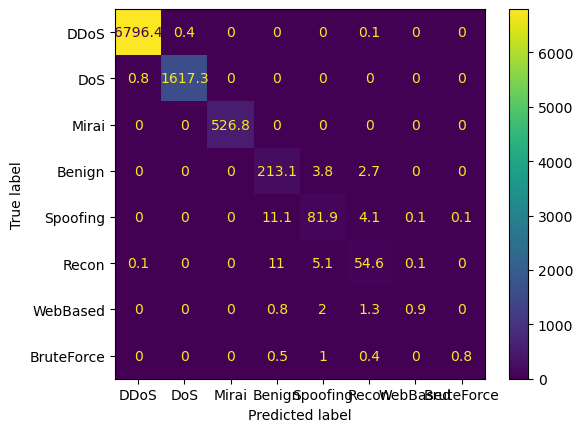

In [53]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [54]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [55]:
%%time
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 5h 12min 6s, sys: 1min 24s, total: 5h 13min 31s
Wall time: 6min 22s


In [56]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9968157873204677),
                ('Precision (Macro)', 0.9546336945869945),
                ('Precision (Micro)', 0.9968157873204677),
                ('Precision (Weighted)', 0.9968009568542577),
                ('Recall (Macro)', 0.8663623517721145),
                ('Recall (Micro)', 0.9968157873204677),
                ('Recall (Weighted)', 0.9968157873204677),
                ('F1 (Macro)', 0.9009835635831827),
                ('F1 (Micro)', 0.9968157873204677),
                ('F1 (Weighted)', 0.9967622132997149)])


In [57]:
process_classification_report(y_full_test, y_full_pred)

              precision    recall  f1-score   support

        DDoS   0.999964  0.999756  0.999860   6796912
         DoS   0.999167  0.999836  0.999501   1618147
       Mirai   0.999915  0.999922  0.999918    526825
      Benign   0.937630  0.977550  0.957174    219639
    Spoofing   0.923324  0.890813  0.906777     97301
       Recon   0.907949  0.871561  0.889383     70913
    WebBased   0.914467  0.579138  0.709160      4966
  BruteForce   0.954654  0.612323  0.746095      2613

    accuracy                       0.996816   9337316
   macro avg   0.954634  0.866362  0.900984   9337316
weighted avg   0.996801  0.996816  0.996762   9337316



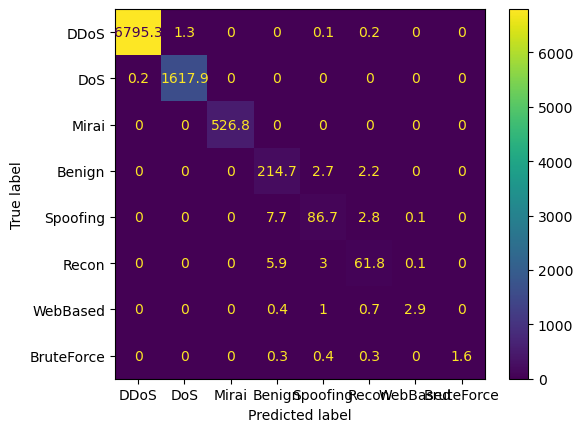

In [58]:
process_confusion_matrix(y_full_test, y_full_pred)